In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['JAVA_HOME'] = '/Users/sb0487/Desktop/sb0487/pyspark/zulu15.32.15-ca-jdk15.0.3-macosx_aarch64/zulu-15.jdk/Contents/Home' 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from ipywidgets import interact, interact_manual
from pyspark.sql.window import Window
import pendulum as plm
from pyspark.sql.types import IntegerType
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [3]:
from pyspark.sql import SparkSession as Session
from pyspark import SparkConf as Conf
from pyspark.sql import functions as F, Window as W
C = F.col

In [4]:
conf = (Conf()
        .set("spark.sql.sources.partitionOverwriteMode", "dynamic")
        .set("spark.driver.memory", "3g")
        .set("spark.sql.broadcastTimeout", "10200")
        .set("spark.driver.maxResultSize", "1g")
#         .set("spark.local.dir","/buffer") 指定shuffle write的路徑
       ) 

In [5]:
spark = (Session
         .builder
         .appName("tradddddd")
         .master("local[4]")# 核心數量
         .config(conf=conf)
         .getOrCreate())

In [6]:
# UI
spark

# load data

data datarange: 20200104~20210625

In [7]:
sdf = spark.read.csv("/Users/sb0487/Desktop/sb0487/finance/project_stock/data/TXF_investor_chip_no_adjust.csv",header = True)


## load my package

In [11]:
# load my package
import sys
sys.path.append("/Users/sb0487/Desktop/sb0487/finance/project_stock/")
from func_utils.utils import format_columns_name, format_value,extend_feature

## format

In [12]:
# 將日期，收盤價等轉為英文
formatted_columns_name_sdf = format_columns_name(sdf)
# 將原始資料中，"口"去除，並轉為int tpye
formatted_value_sdf = format_value(formatted_columns_name_sdf,replace_char="口")


## feature extension

In [13]:
# 擴展特徵，目前只支援一階差分，未來可能可以加入sma等，使其可以擁有型態資訊
extended_feature_sdf = extend_feature(formatted_value_sdf,lag1=True)

In [14]:
extended_feature_df = extended_feature_sdf.toPandas()
extended_feature_df

,Date,Open,High,Low,Close,外資及陸資交易買口,外資及陸資交易賣口,外資及陸資交易淨口,投信交易買口,投信交易賣口,...,∆自營商未平倉賣口,∆自營商未平倉淨口,∆前十大法人買口,∆前十大法人賣口,∆前十大特定法人買口,∆前十大特定法人賣口,∆前五大法人買口,∆前五大法人賣口,∆前五大特定法人買口,∆前五大特定法人賣口
0,2010-01-05,8212,8260,8125,8178,6648,6982,-334,757,821,...,-879,1406,2316,851,1870,2040,1033,357,570,357
1,2010-01-06,8197,8336,8179,8321,9592,7982,1610,479,353,...,1381,1864,2963,301,2582,-1342,2346,147,535,-1405
2,2010-01-07,8335,8355,8230,8260,9757,17049,-7292,391,298,...,-698,1517,-1209,1874,-3988,2961,174,888,-1151,2440
3,2010-01-08,8287,8297,8183,8277,5954,7364,-1410,495,562,...,1272,-59,633,1769,-18,1589,722,779,-10,-1168
4,2010-01-11,8278,8353,8251,8322,7785,5325,2460,677,533,...,195,356,1083,1012,2208,917,574,571,326,2518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,2021-06-21,17048,17149,16891,16963,81392,81266,126,37,965,...,889,110,1612,1161,936,1161,71,484,71,484
2818,2021-06-22,17155,17180,16988,17026,57672,57277,395,31,95,...,1632,-1638,599,-813,-122,-3838,20,-339,20,-339
2819,2021-06-23,17100,17319,17059,17267,67540,68947,-1407,1076,8,...,1032,-929,-1364,1059,-769,4084,111,1210,111,1210
2820,2021-06-24,17298,17398,17261,17338,47153,46180,973,85,0,...,469,-894,-1093,-58,-553,-3048,-683,-245,-683,-245


In [15]:
# 檢查有無缺失值
extended_feature_df.isnull().any()

Date           False
Open           False
High           False
Low            False
Close          False
外資及陸資交易買口      False
外資及陸資交易賣口      False
外資及陸資交易淨口      False
投信交易買口         False
投信交易賣口         False
投信交易淨口         False
自營商交易買口        False
自營商交易賣口        False
自營商交易淨口        False
外資及陸資未平倉買口     False
外資及陸資未平倉賣口     False
外資及陸資未平倉淨口     False
投信未平倉買口        False
投信未平倉賣口        False
投信未平倉淨口        False
自營商未平倉買口       False
自營商未平倉賣口       False
自營商未平倉淨口       False
前十大法人買口        False
前十大法人賣口        False
前十大特定法人買口      False
前十大特定法人賣口      False
前五大法人買口        False
前五大法人賣口        False
前五大特定法人買口      False
前五大特定法人賣口      False
∆外資及陸資交易買口     False
∆外資及陸資交易賣口     False
∆外資及陸資交易淨口     False
∆投信交易買口        False
∆投信交易賣口        False
∆投信交易淨口        False
∆自營商交易買口       False
∆自營商交易賣口       False
∆自營商交易淨口       False
∆外資及陸資未平倉買口    False
∆外資及陸資未平倉賣口    False
∆外資及陸資未平倉淨口    False
∆投信未平倉買口       False
∆投信未平倉賣口       False
∆投信未平倉淨口       False
∆自營商未平倉買口      False
∆自營商未平倉賣口    

In [16]:
# 設定index
extended_feature_df.index = pd.to_datetime(extended_feature_df.Date) 

# 切分樣本內樣本外

In [17]:
from func_utils.utils import train_val_split
train_df,val_df =  train_val_split(extended_feature_df)

# 檢定

若變數很多，可用向量自回歸 or 格蘭傑因果檢定做初步篩選

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [19]:
#範例
data = train_df[["Close", "外資及陸資未平倉淨口"]].pct_change().dropna()
grangercausalitytests(data, 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7829  , p=0.3763  , df_denom=1970, df_num=1
ssr based chi2 test:   chi2=0.7841  , p=0.3759  , df=1
likelihood ratio test: chi2=0.7840  , p=0.3759  , df=1
parameter F test:         F=0.7829  , p=0.3763  , df_denom=1970, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4428  , p=0.6423  , df_denom=1967, df_num=2
ssr based chi2 test:   chi2=0.8879  , p=0.6415  , df=2
likelihood ratio test: chi2=0.8877  , p=0.6416  , df=2
parameter F test:         F=0.4428  , p=0.6423  , df_denom=1967, df_num=2


{1: ({'ssr_ftest': (0.7829470495947514, 0.3763493224928942, 1970.0, 1),
   'ssr_chi2test': (0.7841393547464184, 0.37587816007961083, 1),
   'lrtest': (0.783983573786827, 0.37592558347041594, 1),
   'params_ftest': (0.7829470495935615, 0.3763493224932276, 1970.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4428078516457866, 0.6422946029991181, 1967.0, 2),
   'ssr_chi2test': (0.88786688708235, 0.64150811591499, 2),
   'lrtest': (0.8876670719000685, 0.6415722106472701, 2),
   'params_ftest': (0.4428078516458464, 0.642294602999048, 1967.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

# 回測

**回測套件評估**

1. 使用第三方套件會比手刻更穩固

2. TA-Lib, Zipline 不支援 arm64 

3. 因此使用回測套件: backtesting 

**策略說明**
1. 將凱基XQ台指與其籌碼資料抓下來

2. 對其做簡單的特徵擴展，目前只有做一階差分

3. 切分樣本內與樣本外，default = 0.7

4. 對籌碼使用簡單的均線策略，於樣本內做最佳化，於樣本外驗證

5. 手續費+滑價 = 0.2%

In [20]:
import sys, setuptools, tokenize
from backtesting import Backtest, Strategy #引入回測和交易策略功能
from backtesting.lib import crossover #從lib子模組引入判斷均線交會功能
from backtesting.test import SMA #從test子模組引入繪製均線功能


/opt/homebrew/Caskroom/miniforge/base/envs/stock_dl/lib/python3.8/site-packages/backtesting/_plotting.py:45: UserWarning:

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.



Loading BokehJS ...

## 樣本內最佳化

利用籌碼資訊的長短均線交叉作為台指買賣點

In [46]:
def optimize(train_df, SmaCross,column = None, cash=500000,commission=.002):
    class SmaCross(Strategy): 
        """Strategy""" 
        n1 = 0 
        n2 = 0
        column = ""
        def init(self):
            self.sma1 = self.I(SMA, self.data[column], self.n1) 
            self.sma2 = self.I(SMA, self.data[column], self.n2) 

        def next(self):
            if crossover(self.sma1, self.sma2): 
                self.buy()
            elif crossover(self.sma2, self.sma1): 
                self.sell()
    """最佳化"""
    bt = Backtest(train_df, SmaCross, cash=cash, commission=commission,exclusive_orders=True)
    result = bt.optimize(n1 =range(1, 10, 2),
                    n2 =range(11, 30, 2),
                    method='grid',
                    maximize = "Sharpe Ratio" # maximum 夏普
                   )
    """plot"""
    bt.plot()
    
    """印出最佳參數"""
    print("最佳參數",result["_strategy"])
    return result

In [48]:
optimize(train_df, SmaCross,column = "外資及陸資未平倉淨口", cash=500000,commission=.002)
 

/opt/homebrew/Caskroom/miniforge/base/envs/stock_dl/lib/python3.8/site-packages/backtesting/backtesting.py:1361: UserWarning:

For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.



  0%|          | 0/9 [00:00<?, ?it/s]

最佳參數 SmaCross(n1=3,n2=15)


Start                     2010-01-05 00:00:00
End                       2017-12-29 00:00:00
Duration                   2915 days 00:00:00
Exposure Time [%]                   98.936709
Equity Final [$]                  1203854.478
Equity Peak [$]                   1220440.626
Return [%]                         140.770896
Buy & Hold Return [%]               30.019565
Return (Ann.) [%]                   11.864101
Volatility (Ann.) [%]               17.135891
Sharpe Ratio                         0.692354
Sortino Ratio                        1.157129
Calmar Ratio                         0.552238
Max. Drawdown [%]                  -21.483692
Avg. Drawdown [%]                   -3.208368
Max. Drawdown Duration      538 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                  189
Win Rate [%]                        46.560847
Best Trade [%]                       11.57144
Worst Trade [%]                     -4.889251
Avg. Trade [%]                    

## 樣本外驗證

In [70]:
class SmaCross(Strategy): 
    n1 = 3
    n2 = 15
    column = "外資及陸資未平倉淨口"
    def init(self):
        self.sma1 = self.I(SMA, self.data[column], self.n1) 
        self.sma2 = self.I(SMA, self.data[column], self.n2) 

    def next(self):
        if crossover(self.sma1, self.sma2): 
            self.buy()
        elif crossover(self.sma2, self.sma1): 
            self.sell()

In [51]:
def val(val_df, SmaCross,column = None, cash=500000,commission=.002):
    """Strategy""" 
    class SmaCross(Strategy): 
        n1 = 3
        n2 = 15
        column = None
        def init(self):
            self.sma1 = self.I(SMA, self.data[column], self.n1) 
            self.sma2 = self.I(SMA, self.data[column], self.n2) 

        def next(self):
            if crossover(self.sma1, self.sma2): 
                self.buy()
            elif crossover(self.sma2, self.sma1): 
                self.sell()
    """最佳化"""
    bt = Backtest(val_df, SmaCross, cash=cash, commission=commission,exclusive_orders=True)
    result = bt.run()
    """plot"""
    bt.plot()
    return result

In [52]:
val(val_df, SmaCross,column = "外資及陸資未平倉淨口", cash=500000,commission=.001)

Start                     2018-01-03 00:00:00
End                       2021-06-25 00:00:00
Duration                   1269 days 00:00:00
Exposure Time [%]                   97.399527
Equity Final [$]                   701153.879
Equity Peak [$]                    731445.303
Return [%]                          40.230776
Buy & Hold Return [%]               61.503522
Return (Ann.) [%]                   10.596292
Volatility (Ann.) [%]                21.16112
Sharpe Ratio                         0.500743
Sortino Ratio                         0.85877
Calmar Ratio                         0.373878
Max. Drawdown [%]                  -28.341566
Avg. Drawdown [%]                   -3.721105
Max. Drawdown Duration      471 days 00:00:00
Avg. Drawdown Duration       48 days 00:00:00
# Trades                                   88
Win Rate [%]                        56.818182
Best Trade [%]                       8.599085
Worst Trade [%]                    -13.589235
Avg. Trade [%]                    

## 如果要看3D圖的話

ps: 沒做過unittest
不確定是否有錯誤

In [73]:
column = "外資及陸資未平倉淨口"

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
def get_optimize_3d_graphics(train_df:"your df",
                             SmaCross, cash=500000,
                             commission=.001,
                             n1_range = np.arange(1, 4, 1),
                             n2_range = np.arange(3, 7, 1)):

    X, Y = np.meshgrid(n1_range, n2_range)
    m,n = X.shape
    m_list = []
    for i in range(m):
        n_list = []
        for j in range(n):
            param1 = X[i][j]
            param2 = Y[i][j]           
            result = Backtest(extended_feature_df, SmaCross, cash=cash, commission = commission).run(n1 = param1,n2 =  param2)["Sharpe Ratio"]
            n_list.append(result)
        m_list.append(n_list)
        result_array =  np.array(m_list)
    # 繪圖
    fig = plt.figure(figsize=(14, 14))
    axis = fig.gca(projection='3d')
    surface = axis.plot_surface(X, Y, result_array, rstride=1, cstride=1, cmap='coolwarm_r')
    fig.colorbar(surface, shrink=1.0, aspect=400)
    
    
    # 設置圖表訊息
    plt.title("Sharpe Ratio", fontsize=16)
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)
    plt.show()
    return None


<ipython-input-74-1579ecb9136f>:24: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



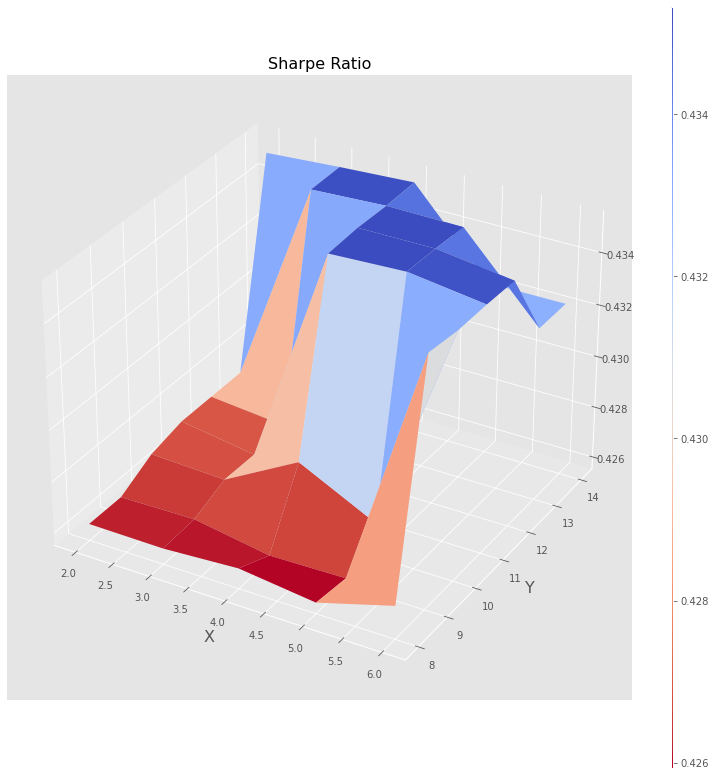

In [75]:
get_optimize_3d_graphics(train_df,SmaCross,cash = 500000, commission=.001, n1_range = np.arange(2, 7, 1),n2_range = np.arange(8, 15, 1))


# 結論與檢討

**結論**
1. 一頓操作累如鼠，夏普只有0.5
**可能可嘗試**
1. 特徵工程使用Factoriztion-Machine
2. 如何獲得數據背後的隱藏資訊
**其他**
1. 若使用第三方套件可能要先評估正確性